In [100]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import pyplot

pd.set_option("display.precision", 2)
%matplotlib inline

import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance

In [101]:
# Create numerical parameters for dataframe

def create_num_params(df):
    df["age_approx"] = df["age_approx"]/df["age_approx"].max()

    df["female"] = [1 if x == 'female' else 0 for x in df['sex']]
    df["male"] = [1 if x == 'male' else 0 for x in df['sex']]

    df["head_neck"] = [1 if x == 'head/neck' else 0 for x in df['anatom_site_general_challenge']]
    df["torso"] = [1 if x == 'torso' else 0 for x in df['anatom_site_general_challenge']]
    df["lower_extremity"] = [1 if x == 'lower extremity' else 0 for x in df['anatom_site_general_challenge']]
    df["upper_extremity"] = [1 if x == 'upper extremity' else 0 for x in df['anatom_site_general_challenge']]
    df["palms_soles"] = [1 if x == 'palms/soles' else 0 for x in df['anatom_site_general_challenge']]
    df["oral_genital"] = [1 if x == 'oral/genital' else 0 for x in df['anatom_site_general_challenge']]  

In [102]:
# Optional for creating more parameters

def create_more_params(df):
    df = df.assign(min_visit_age = df.groupby('patient_id').age_approx.transform('min'))
    df = df.assign(max_visit_age = df.groupby('patient_id').age_approx.transform('max'))
    df = df.assign(total_visits = df.groupby('patient_id').age_approx.transform('count'))

    df = df.assign(images_torso = df.groupby(['patient_id'])['torso'].transform('sum'))
    df = df.assign(images_lower_ex = df.groupby(['patient_id'])['lower_extremity'].transform('sum'))
    df = df.assign(images_upper_ex = df.groupby(['patient_id'])['upper_extremity'].transform('sum'))
    df = df.assign(images_head_neck = df.groupby(['patient_id'])['head_neck'].transform('sum'))
    df = df.assign(images_palms_soles = df.groupby(['patient_id'])['palms_soles'].transform('sum'))
    df = df.assign(images_oral_gen = df.groupby(['patient_id'])['oral_genital'].transform('sum'))

In [103]:
df = pd.read_csv("/home/leslie/code/melanoma_files/train.csv")

## Create numbered parameters and drop unnecessary columns

In [104]:
create_num_params(df)

In [105]:
create_more_params(df)

In [106]:
# Getting rid of a few columns like "image_name", etc.
df=df.drop(columns=['image_name', 'sex', 'anatom_site_general_challenge','benign_malignant','diagnosis'])

## Extract, create list of unique patient numbers

In [107]:
df["patient_id"] = pd.to_numeric(df["patient_id"].str[3:])

In [108]:
unique_patients = set()

for index in range(len(df)):
    unique_patients.add(df["patient_id"].iloc[index])
    
unique_patients = list(unique_patients)

## Use unique patient_id list to split into train and test so that images from the same patients don't end up in both dataframes

In [109]:
random.shuffle(unique_patients)
train_size = int(round(len(unique_patients)*0.8, 0))

In [110]:
train = unique_patients[:train_size]
test = unique_patients[train_size:]

x_train = df[df["patient_id"].isin(train)]
x_test = df[df["patient_id"].isin(test)]

# Create y_train and y_test, each of which have one "target" column
y_train = x_train.target
y_test = x_test.target

## Drop "target" and "patient_id" column

In [111]:
x_train=x_train.drop(columns=['target', 'patient_id'])
x_test=x_test.drop(columns=['target', 'patient_id'])

## Create the model and get predictions

In [118]:
model = XGBClassifier(objective = 'binary:logistic')
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# make predictions for test data
y_pred = model.predict(x_test)

## Find mean squared error and calculate accuracy of the model

In [124]:
mean_squared_error(y_test, y_pred)

0.020949944026867104

In [125]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.91%


### See which features affect the model the most

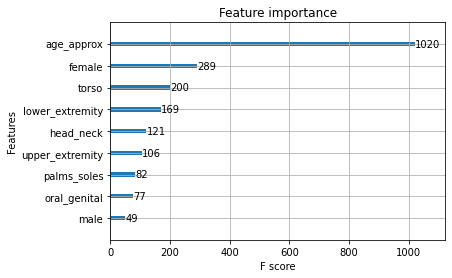

In [127]:
plot_importance(model)
pyplot.show()

# Attempt with test.csv

In [128]:
df = pd.read_csv("/home/leslie/code/melanoma_files/test.csv")
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


## Designate df_image_ids (to append to results later), create numbered parameters, and drop unnecessary columns

In [129]:
df_image_ids = df['image_name']

create_num_params(df)
create_more_params(df)

In [130]:
df=df.drop(columns=['image_name', 'sex', 'anatom_site_general_challenge', 'patient_id'])

## Create a model for predicting probabilities including numbers between 0 and 1

In [131]:
y_pred = model.predict_proba(df)

### Since two probabilities for each image are generated - one for probability a lesion is benign and one for probability a lesion is malignant - delete the probability that predicts the likeliness a lesion is benign

In [132]:
y_pred = np.delete(y_pred, 0, 1)

(array([1.0363e+04, 3.8700e+02, 1.4100e+02, 5.1000e+01, 1.0000e+01,
        6.0000e+00, 0.0000e+00, 1.4000e+01, 0.0000e+00, 9.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.00087844, 0.0370467 , 0.07321496, 0.10938323, 0.14555149,
        0.18171975, 0.21788801, 0.25405627, 0.29022455, 0.3263928 ,
        0.36256108, 0.39872932, 0.4348976 , 0.47106585, 0.5072341 ,
        0.5434024 , 0.57957065, 0.6157389 , 0.65190715, 0.6880754 ,
        0.7242437 ], dtype=float32),
 <a list of 20 Patch objects>)

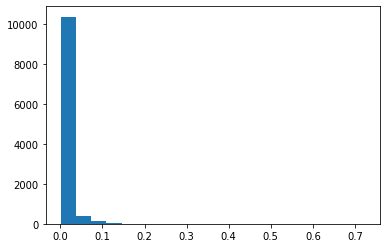

In [135]:
plt.hist(y_pred, bins = 20)

In [70]:
df_y = pd.DataFrame(data=y_pred,columns=['target'])

## Add the df_image_ids from earlier and export final results from test.csv

In [71]:
result = pd.concat([df_image_ids, df_y], axis=1, sort=False)

In [72]:
result

,image_name,target
0,ISIC_0052060,3.75e-02
1,ISIC_0052349,8.17e-03
2,ISIC_0058510,1.44e-02
3,ISIC_0073313,6.74e-03
4,ISIC_0073502,5.29e-03
...,...,...
10977,ISIC_9992485,7.17e-03
10978,ISIC_9996992,3.70e-03
10979,ISIC_9997917,4.04e-02
10980,ISIC_9998234,1.97e-02


In [73]:
result.to_csv('submission.csv', index = False, header = 1)